## Traininig the Inclusive classifier with tf.keras using data in TFRecord format

**tf.keras Inclusive classifier, GRU-based model** This notebooks trains a neural network for a particle classifier using the Inclusive Classifier model, using as input the full list of reconstructed particles + the High Level Features. Data is prepared in TFRecord format converting from Parquet using Apache Spark. Tensorflow data procesing uses tf.data and tf.io.  

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger  

The model is a classifier implemented as the concatenation of a Dense Neural Network and a Recurrent Neural Network (GRU)
 - input: 14 high-level features and an array of 801 particles with 19 low-level features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)


## Create the Keras model for the inclusive classifier

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

2024-06-10 10:40:54.316468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 10:41:11.532889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.version.VERSION

'2.16.1'

In [3]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

2024-06-10 10:41:35.815492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-06-10 10:41:36.079411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 10:41:36.079970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
## GRU branch
gru_input = Input(shape=(801,19), name='gru_input')
a = gru_input
a = Masking(mask_value=0.)(a)
a = GRU(units=50,activation='tanh')(a)
gruBranch = Dropout(0.2)(a)

2024-06-10 10:44:14.448435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 10:44:14.449154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-10 10:44:14.449572: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
hlf_input = Input(shape=(14,), name='hlf_input')
b = hlf_input
hlfBranch = Dropout(0.2)(b)

In [6]:
c = concatenate([gruBranch, hlfBranch])
c = Dense(25, activation='relu')(c)
output = Dense(3, activation='softmax')(c)

In [7]:
model = Model(inputs=[gru_input, hlf_input], outputs=output)

In [8]:
## Compile model
optimizer = 'Adam'
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ gru_input           │ (None, 801, 19)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 801, 19)   │          0 │ gru_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 801, 19)   │          0 │ gru_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 801)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 50)        │     10,650 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hlf_input           │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50)        │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 14)        │          0 │ hlf_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25)        │      1,625 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         78 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,353 (48.25 KB)

 Trainable params: 12,353 (48.25 KB)

 Non-trainable params: 0 (0.00 B)

## Load test and training data in TFRecord format, using tf.data and tf.io

In [10]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
FOLDER = "/eos/project/s/sparkdltrigger/public/"

PATH = FOLDER + "testUndersampled_InclusiveClassifier.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", shuffle=False)

# training dataset 
PATH = FOLDER + "trainUndersampled_InclusiveClassifier.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", seed=4242)

In [11]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
# Function to decode TFRecord data into the required features and labels
# In particular, GRU_input is stored has a flat array and needs to be resized as (801,19)

def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [13]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [14]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
# Show and example of the parsed data
# for record in parsed_test_dataset.take(1):
#     print(record)

In [16]:
# tunable
batch_size=128

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 801, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [17]:
# tunable
test_batch_size = 10240

test=parsed_test_dataset.batch(batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Train the tf.keras model

In [18]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, validation_data=test, epochs=num_epochs, callbacks=callbacks)


Epoch 1/6


2024-06-10 10:44:41.981079: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  26767/Unknown 1020s 38ms/step - accuracy: 0.8840 - loss: 0.3025

2024-06-10 11:01:37.087523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 11:01:37.087663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_8]]
2024-06-10 11:01:37.087701: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18406279820982204997
2024-06-10 11:01:37.087721: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5653500068715384509
2024-06-10 11:01:37.087756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6795041787301890416
2024-06-10 11:01:37.087774: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5727204299290059

26767/26767 ━━━━━━━━━━━━━━━━━━━━ 1226s 45ms/step - accuracy: 0.8840 - loss: 0.3025 - val_accuracy: 0.9410 - val_loss: 0.1619
Epoch 2/6


2024-06-10 11:05:03.008104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 11:05:03.008208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-10 11:05:03.008235: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8128022108319157141
2024-06-10 11:05:03.008251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
2024-06-10 11:05:03.008288: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 11:05:03.008322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804


26766/26767 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9392 - loss: 0.1673

2024-06-10 11:21:25.057414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 11:21:25.057513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-10 11:21:25.057597: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5653500068715384509
2024-06-10 11:21:25.057762: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6795041787301890416
2024-06-10 11:21:25.057806: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5727204299290059326


26767/26767 ━━━━━━━━━━━━━━━━━━━━ 1160s 43ms/step - accuracy: 0.9392 - loss: 0.1673 - val_accuracy: 0.9487 - val_loss: 0.1402
Epoch 3/6


2024-06-10 11:24:22.802940: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 11:24:22.803015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-10 11:24:22.803050: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8128022108319157141
2024-06-10 11:24:22.803066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
2024-06-10 11:24:22.803104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 11:24:22.803123: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804


26766/26767 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9469 - loss: 0.1471

2024-06-10 11:41:11.375587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 11:41:11.375703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_8]]
2024-06-10 11:41:11.375731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18406279820982204997
2024-06-10 11:41:11.375747: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5653500068715384509
2024-06-10 11:41:11.375801: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6795041787301890416
2024-06-10 11:41:11.375820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5727204299290059

26767/26767 ━━━━━━━━━━━━━━━━━━━━ 1166s 44ms/step - accuracy: 0.9469 - loss: 0.1471 - val_accuracy: 0.9512 - val_loss: 0.1334
Epoch 4/6


2024-06-10 11:43:48.384118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 11:43:48.384193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-10 11:43:48.384216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8128022108319157141
2024-06-10 11:43:48.384232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
2024-06-10 11:43:48.384287: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 11:43:48.384320: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804


26767/26767 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9502 - loss: 0.1392

2024-06-10 12:00:54.274211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_1_1/dropout_1_2/Shape/_16]]
2024-06-10 12:00:54.274290: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6795041787301890416
2024-06-10 12:00:54.274311: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 15059145612970629766
2024-06-10 12:00:54.274332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5653500068715384509
2024-06-10 12:00:54.274355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


26767/26767 ━━━━━━━━━━━━━━━━━━━━ 1224s 46ms/step - accuracy: 0.9502 - loss: 0.1392 - val_accuracy: 0.9539 - val_loss: 0.1279
Epoch 5/6


2024-06-10 12:04:12.104389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 12:04:12.104470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-10 12:04:12.104501: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8128022108319157141
2024-06-10 12:04:12.104517: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
2024-06-10 12:04:12.104540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 12:04:12.104575: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804


26766/26767 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9521 - loss: 0.1341

2024-06-10 12:21:25.951562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 12:21:25.951785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_1_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_20]]
2024-06-10 12:21:25.951850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6795041787301890416
2024-06-10 12:21:25.951900: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous send item cancelled. Key hash: 18257346834832859812
2024-06-10 12:21:25.951923: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5727204299290059326
2024-06-10 12:21:25.951949: I tensorflow/core/frame

26767/26767 ━━━━━━━━━━━━━━━━━━━━ 1280s 48ms/step - accuracy: 0.9521 - loss: 0.1341 - val_accuracy: 0.9567 - val_loss: 0.1206
Epoch 6/6


2024-06-10 12:25:32.543792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 12:25:32.543878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-10 12:25:32.543902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8128022108319157141
2024-06-10 12:25:32.543917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
2024-06-10 12:25:32.543939: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 12:25:32.543973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804


26766/26767 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9531 - loss: 0.1307

2024-06-10 12:43:25.989283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 12:43:25.989396: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6795041787301890416
2024-06-10 12:43:25.989420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5727204299290059326
2024-06-10 12:43:25.989443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5653500068715384509
2024-06-10 12:43:25.989467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


26767/26767 ━━━━━━━━━━━━━━━━━━━━ 1288s 48ms/step - accuracy: 0.9531 - loss: 0.1307 - val_accuracy: 0.9564 - val_loss: 0.1209
CPU times: user 2h 58min 32s, sys: 48min 10s, total: 3h 46min 43s
Wall time: 2h 2min 23s


2024-06-10 12:47:00.353288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 12:47:00.353371: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 12:47:00.353397: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804
2024-06-10 12:47:00.353420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
2024-06-10 12:47:00.353444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


In [18]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, validation_data=test, epochs=num_epochs, callbacks=callbacks)


Epoch 1/6
26767/26767 [==============================] - 1048s 39ms/step - loss: 0.2333 - accuracy: 0.9134 - val_loss: 0.1587 - val_accuracy: 0.9418
Epoch 2/6
26767/26767 [==============================] - 1045s 39ms/step - loss: 0.1526 - accuracy: 0.9449 - val_loss: 0.1326 - val_accuracy: 0.9520
Epoch 3/6
26767/26767 [==============================] - 1102s 41ms/step - loss: 0.1382 - accuracy: 0.9504 - val_loss: 0.1243 - val_accuracy: 0.9557
Epoch 4/6
26767/26767 [==============================] - 1075s 40ms/step - loss: 0.1333 - accuracy: 0.9522 - val_loss: 0.1209 - val_accuracy: 0.9566
Epoch 5/6
26767/26767 [==============================] - 1082s 40ms/step - loss: 0.1300 - accuracy: 0.9535 - val_loss: 0.1270 - val_accuracy: 0.9541
Epoch 6/6
26767/26767 [==============================] - 1080s 40ms/step - loss: 0.1274 - accuracy: 0.9543 - val_loss: 0.1187 - val_accuracy: 0.9574
CPU times: user 2h 37min 38s, sys: 1h 59min 27s, total: 4h 37min 5s
Wall time: 1h 47min 32s


In [21]:
# Save the model
tf.keras.models.save_model(model, "./myGRUmodel" + ".keras")

## Performance metrics

<IPython.core.display.Javascript object>


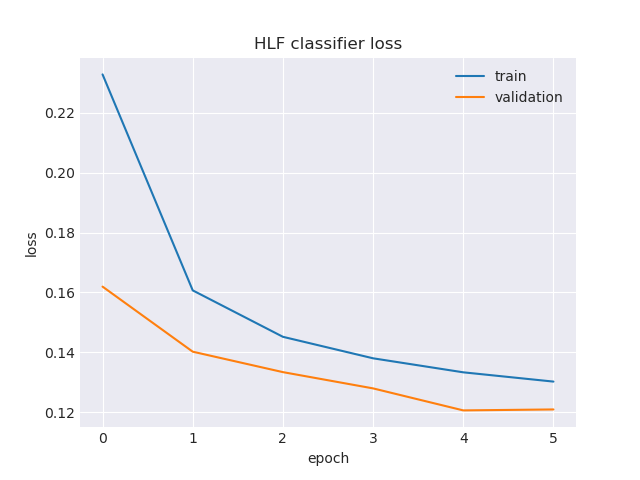

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')

# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


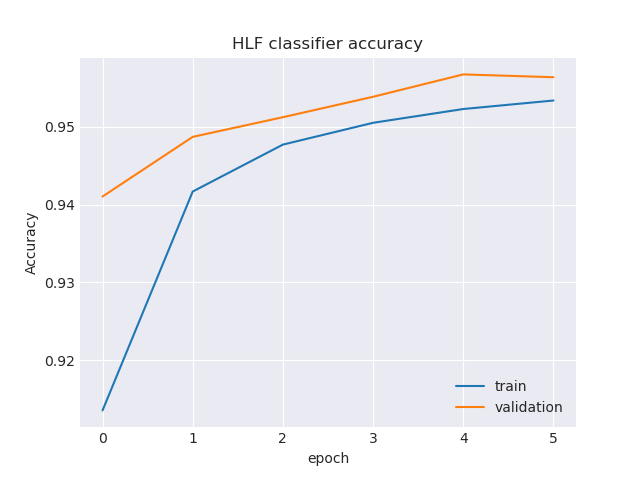

In [23]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [22]:
# model = tf.keras.models.load_model("./mymodel.keras")

In [24]:
%time model.evaluate(test)

6689/6689 ━━━━━━━━━━━━━━━━━━━━ 214s 32ms/step - accuracy: 0.9567 - loss: 0.1203
CPU times: user 4min 22s, sys: 1min 38s, total: 6min
Wall time: 3min 34s


2024-06-10 14:08:51.548951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-10 14:08:51.549047: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7742408594649725250
2024-06-10 14:08:51.549074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-10 14:08:51.549138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14524028611921967804
2024-06-10 14:08:51.549163: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12098498567825599658
2024-06-10 14:08:51.549186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11616133789228365487
/cvmfs/s

[0.12089300900697708, 0.9563643932342529]

In [25]:
%time y_pred = model.predict(test)

6689/6689 ━━━━━━━━━━━━━━━━━━━━ 234s 35ms/step


2024-06-10 14:12:45.980309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


CPU times: user 4min 15s, sys: 1min 34s, total: 5min 49s
Wall time: 4min


In [26]:
%time y_true = np.stack([labels.numpy() for features,labels in parsed_test_dataset.__iter__()])

2024-06-10 14:20:46.246490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


CPU times: user 7min 59s, sys: 1min 36s, total: 9min 35s
Wall time: 7min 55s


In [27]:
from sklearn.metrics import accuracy_score

print('Accuracy of the classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the classifier: 0.9564


<IPython.core.display.Javascript object>


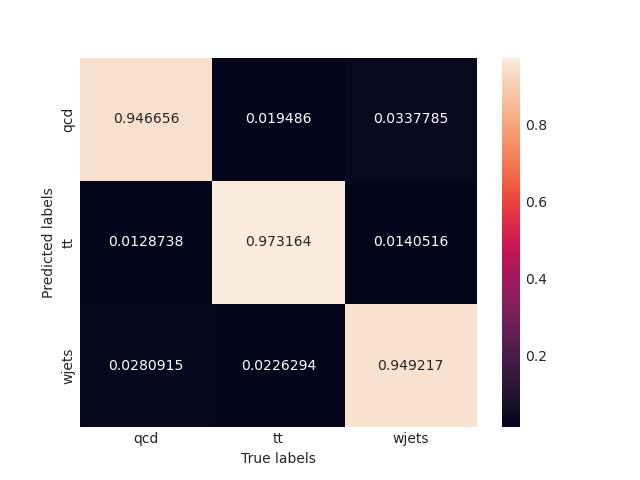

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [30]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [31]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9950259951954981, 1: 0.9969318375076833, 2: 0.9947263829137812}

<IPython.core.display.Javascript object>


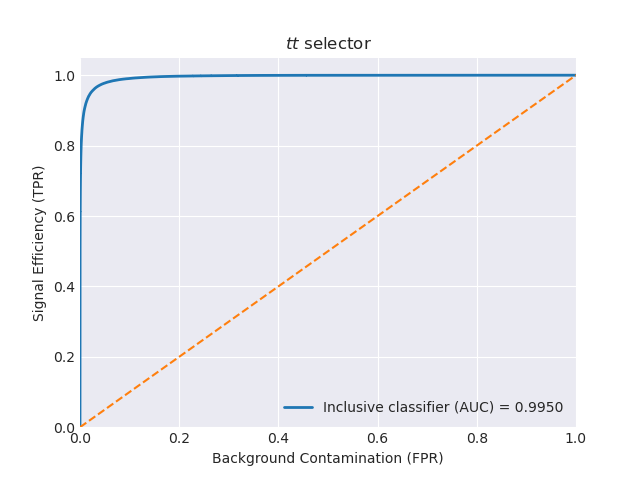

In [32]:
%matplotlib notebook
plt.style.use('seaborn-v0_8-darkgrid')
# Plot roc curve 
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='Inclusive classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()